# Final Project: Earth Analytics Python Course, Spring 2020
## Steph Shepherd & Lauren Herwehe

In [1]:
# Import libraries
import warnings
from glob import glob
import os
import sys

import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import geopandas as gpd
from geopandas import GeoDataFrame as gdf
from geopandas import GeoSeries as gs
from shapely.geometry import Point, Polygon
import shapely.speedups
import urllib.request

import contextily as ctx
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from earthpy import clip as cl

from zipfile import ZipFile

# Set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

In [2]:
# Download Data
# Ramsar Sites
urllib.request.urlretrieve(
    "https://ndownloader.figshare.com/articles/12217679/versions/1", "12217679.zip")

with ZipFile('12217679.zip', 'r') as zipObj:
    zipObj.extractall("ramsar")

# Future dams
et.data.get_data(url="https://ndownloader.figshare.com/files/22486157")

'/home/jovyan/earth-analytics/data/earthpy-downloads/future_dams_2015.csv'

In [15]:
# Open the ramsar shapefile with geopandas
ramsar_areas = gpd.read_file(os.path.join(
    "ramsar", "features_publishedPolygon.shp"))

# Check the crs of the ramsar sites
print(ramsar_areas.crs)

# Open the dams csv files with pandas
fname = os.path.join("earthpy-downloads", "future_dams_2015.csv")
df = pd.read_csv(fname)

# Covert the pandas dataframe to a shapefile for plotting
# Set output path for shp
dams_path = os.path.join('final-project-data', 'fhred-proposed-dams')
if not os.path.exists(dams_path):
    os.mkdir(dams_path)

# Define the geometry for the points
geometry = [Point(xy) for xy in zip(df.Lon_Cleaned, df.LAT_cleaned)]
crs = {'init': 'epsg:4326'}
geo_df = gdf(df, crs=crs, geometry=geometry)
geo_df.to_file(driver='ESRI Shapefile', filename=os.path.join(
    dams_path, 'proposed_dams.shp'))

# Open the proposed dams shapefile with geopandas
proposed_dams = gpd.read_file(os.path.join(dams_path, "proposed_dams.shp"))

# Pull only the columns that we need from each gdf to save processing time
proposed_dams = proposed_dams[['Country', 'Continent', 'Major Basi', 'Stage', 'geometry']]
ramsar_areas = ramsar_areas[['country_en', 'geometry']]

# Open country borders shapefile for adding boundary of study area
country_borders_path = os.path.join("final-project-data","country-borders",
                                  "99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp")
country_borders = gpd.read_file(country_borders_path)

epsg:4326


/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  if __name__ == '__main__':


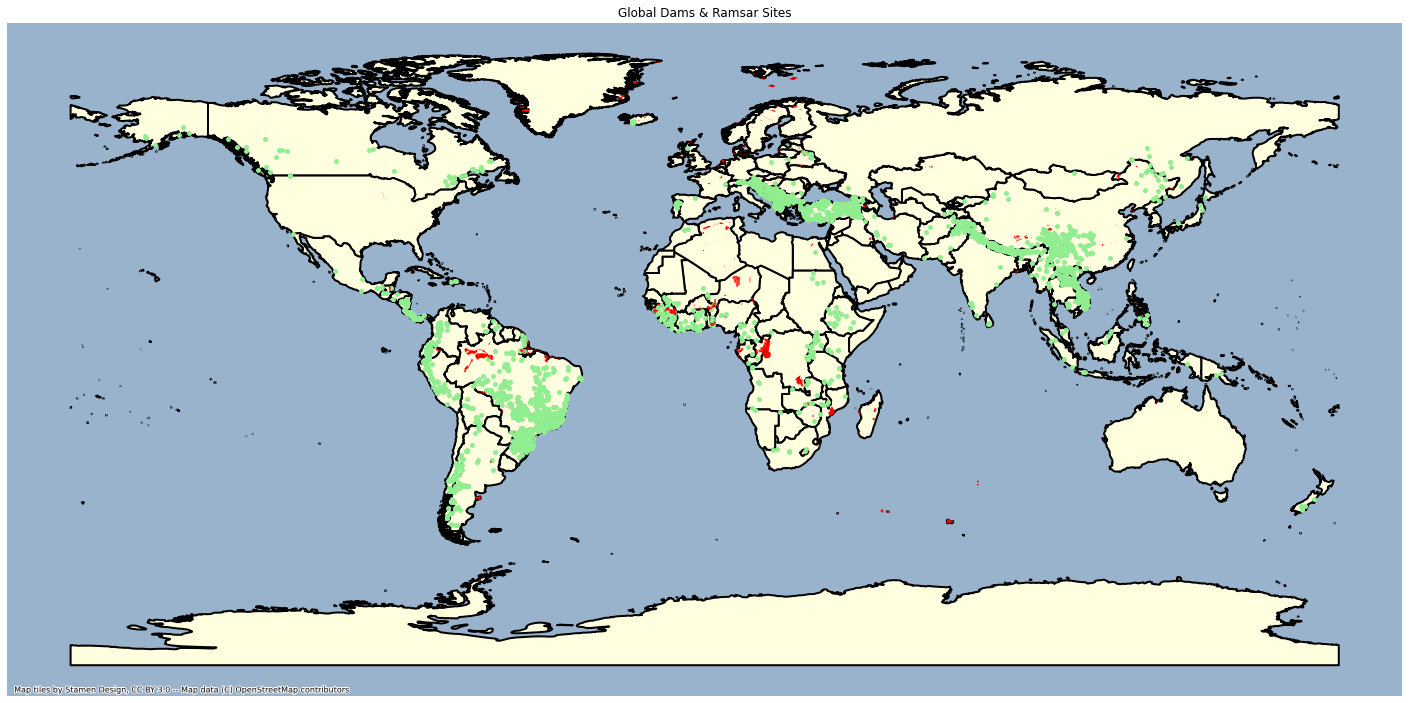

In [20]:
# Create a Global Map of Dams and Ramsar Sites
# Pull only the data for Guinea
fig, ax = plt.subplots(figsize=(25, 35))
country_borders.plot(ax=ax, color="lightyellow",  edgecolor="black", linewidth=2)
proposed_dams.plot(ax=ax,
                         markersize=15,
                         color='lightgreen')
ramsar_areas.plot(ax=ax, facecolor = 'red')
ctx.add_basemap(ax, url=ctx.providers.Stamen.Terrain, zoom=0)
ax.set(title='Global Dams & Ramsar Sites')
ax.set_axis_off()

In [5]:
# Getting Number of Dams by Continent and Development State
# Extact the columns needed for analysis
dams_continent = proposed_dams[['Continent', 'Country', 'Stage']]

# Group and count data by stage.
dams_stage = dams_continent.groupby(['Continent','Country','Stage'])[['Stage']].count()

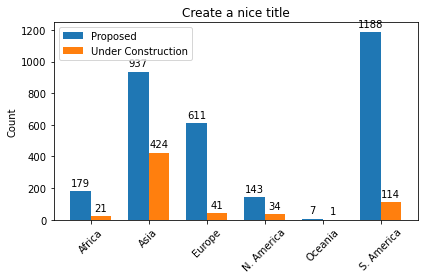

In [6]:
# PLOT - NUMBER OF DAMS PROPOSED VS UNDER CONSTRUCTION BY CONTINENT
# Create a bar plot of the dams by continent and stage of process.
labels = ['Africa', 'Asia', 'Europe', 'N. America', 'Oceania', 'S. America']
proposed = [179, 937, 611, 143, 7, 1188]
under_const = [21, 424, 41, 34, 1, 114]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, proposed, width, label='Proposed')
rects2 = ax.bar(x + width/2, under_const, width, label='Under Construction')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Create a nice title')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its value."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [7]:
# Change the datas CRS to projected for Africa (WGS 84 World Mercator)
# Poses a problem because we need to use a projected rather than geographic CRS to have the buffers measure properly
# If time, create list of EPSG for each country in Africa to include in function
proposed_dams = proposed_dams.to_crs('epsg:3765')
ramsar_areas = ramsar_areas.to_crs('epsg:3765')

In [8]:
def ramsar_area(country):
    """ This function takes a country name and pulls the total area of Ramsar Designated sites for it.

    Parameters
    ----------
    country: str
        Full name of the country to be analyzed in quotes (e.g. 'Mexico').

    Returns
    -------
    total_ramsar: float
        Total area of Ramsar sites in the country.

    """
    # Pull only the data for the country
    proposed_dams_cntry = proposed_dams[proposed_dams['Country'] == country]
    ramsar_areas_cntry = ramsar_areas[ramsar_areas['country_en'] == country]
    total_ramsar = ((ramsar_areas_cntry.area.sum())/1000000).round(1)

    return total_ramsar

In [9]:
def dam_impact(buff_km, country):
    """ This function takes a country name, pulls the proposed 
    dams & ramsar areas for the country, creates a 5km & 10km 
    buffer around the dams, and returns the total ramsar area covered
    by each buffer.

    Parameters
    ----------
    buff_km: int or float
        The number of kilometers buffer you want around the dam.
    country: str
        Full name of the country to be analyzed in quotes.

    Returns
    -------
    ramsar_affected: float
        Total ramsar area affected in the country by proposed dams with buffer.
    """
    # Pull only the data for the country
    proposed_dams_cntry = proposed_dams[proposed_dams['Country'] == country]
    ramsar_areas_cntry = ramsar_areas[ramsar_areas['country_en'] == country]

    # Buffer the dams to 5km & 10km to create gdfs of only the intersections
    proposed_dams_cntry['geometry'] = proposed_dams_cntry.buffer(buff_km * 1000)
    try:
        data_intersect_cntry = gpd.overlay(ramsar_areas_cntry, proposed_dams_cntry, how='intersection')
        ramsar_affected = ((data_intersect_cntry.area.sum())/1000000).round(1) # divide by 1 million because it sq km
        return ramsar_affected
    except IndexError as err:
        Dams = None

In [10]:
# Get dam impact by African country
# List of African country names
africa_cntry = ['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Djibouti', 'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Libya',
                'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe']

# Empty Africa dict
africa_dams = {}

# Append dam_impact function data to africa_dams
for i in africa_cntry:
    try:
        africa_dams[i] = {"5km_buff": dam_impact(5, i), "10km_buff": dam_impact(10, i)}
    except:
        dams = None

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [11]:
# Turn it into a pandas dataframe for plotting
africa_df = pd.DataFrame.from_dict(africa_dams)

# Some values in the dataframe are zero and some are NaN, make it the same
africa_df = africa_df.fillna('None')
africa_df.replace({0 : 'None'})


,Angola,Benin,Botswana,Burkina Faso,Burundi,Cameroon,Central African Republic,Chad,Comoros,Djibouti,...,Sierra Leone,Somalia,South Africa,South Sudan,Sudan,Tanzania,Togo,Uganda,Zambia,Zimbabwe
5km_buff,None,247.9,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
10km_buff,None,972.5,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


Text(0.5, 1.0, 'Dam Impact on Ramsar Areas in Africa')

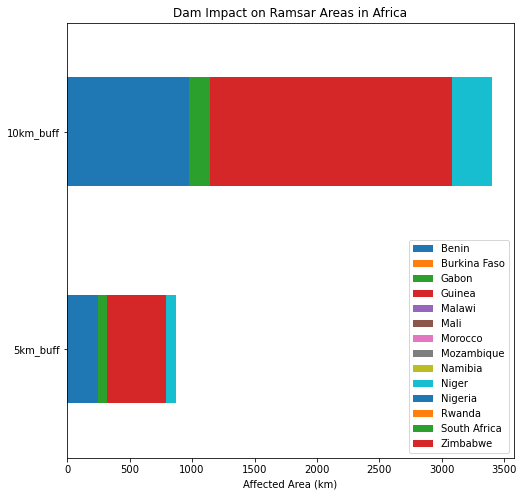

In [12]:
# CAN'T FIGURE OUT HOW TO CREATE A LEGEND THAT ONLY SHOWS COUNTRIES WITHOUT ZERIO AREA (SO JUST FOUR COUNTRIES)
# Create the figure
fig, ax = plt.subplots(figsize=(8, 8))
africa_df.plot(ax=ax, kind='barh', stacked=True, legend=True)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.legend(loc='lower right')
ax.set_xlabel('Affected Area (km)')
ax.set_title('Dam Impact on Ramsar Areas in Africa')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.


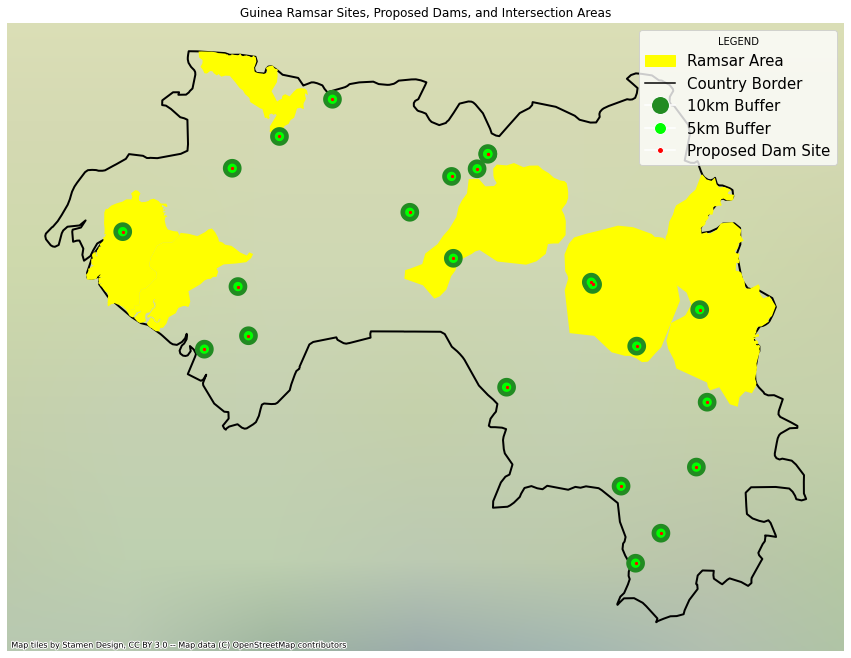

In [13]:
# Analyze Guinea
# Pull only the data for Guinea
proposed_dams_guin = proposed_dams[proposed_dams['Country'] == "Guinea"]
ramsar_areas_guin = ramsar_areas[ramsar_areas['country_en'] == "Guinea"]
guinea_border = country_borders[country_borders['CNTRY_NAME'] == "Guinea"]

# Get the CRS right for plotting
proposed_dams_guin = proposed_dams_guin.to_crs('epsg:3462')
ramsar_areas_guin = ramsar_areas_guin.to_crs('epsg:3462')
guinea_border = guinea_border.to_crs('epsg:3462')

# Buffer the dams to 5km & 10km for plotting
proposed_dams_guin_5k_buff = proposed_dams_guin.buffer(5000)
proposed_dams_guin_10k_buff = proposed_dams_guin.buffer(10000)

# Create a map of the dams and the ramsar sites for Guinea
# Creating a legend VERY MANUALLY bc can't get it to work any other way
yellow_patch = mpatches.Patch(color='yellow', label='Ramsar Area')
black_line = mlines.Line2D([], [], color='black', label='Country Border')
green_circle= mlines.Line2D([], [], color='white', marker='o', markerfacecolor='forestgreen', markersize=18, label='10km Buffer')
lime_circle= mlines.Line2D([], [], color='white', marker='o', markerfacecolor='lime', markersize=12, label='5km Buffer')
red_dot= mlines.Line2D([], [], color='white', marker='o', markerfacecolor='red', label='Proposed Dam Site')

fig, ax = plt.subplots(figsize=(15, 15))
guinea_border.plot(ax=ax, color="none",  edgecolor="black", linewidth=2)
ramsar_areas_guin.plot(ax=ax, facecolor = 'yellow')
proposed_dams_guin_10k_buff.plot(facecolor='forestgreen',
    ax=ax)
proposed_dams_guin_5k_buff.plot(facecolor='lime',
    ax=ax)
proposed_dams_guin.plot(ax=ax,
                         markersize=5,
                         color='red')
ax.legend(handles=[yellow_patch, black_line, green_circle, lime_circle, red_dot],
          fontsize=15,
          frameon=True,
          loc=('upper right'),
          title="LEGEND")
ctx.add_basemap(ax, url=ctx.providers.Stamen.Terrain, zoom=0)
ax.set(title='Guinea Ramsar Sites, Proposed Dams, and Intersection Areas')
ax.set_axis_off()